<a href="https://colab.research.google.com/github/stepan-ds/nlp_for_devs/blob/main/part1/tokenization_and_cosine_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Introduction to Natural Language in Python using spaCy

## Introduction

This tutorial provides a brief introduction to working with natural language (sometimes called "text analytics") in Pytho, using [spaCy](https://spacy.io/) and related libraries.
Data science teams in industry must work with lots of text, one of the top four categories of data used in machine learning.
Usually that's human-generated text, although not always.

Think about it: how does the "operating system" for business work? Typically, there are contracts (sales contracts, work agreements, partnerships), there are invoices, there are insurance policies, there are regulations and other laws, and so on.
All of those are represented as text.

You may run across a few acronyms: _natural language processing_ (NLP), _natural language understanding_ (NLU), _natural language generation_ (NLG) — which are roughly speaking "read text", "understand meaning", "write text" respectively.
Increasingly these tasks overlap and it becomes difficult to categorize any given feature.

The _spaCy_ framework — along with a wide and growing range of plug-ins and other integrations — provides features for a wide range of natural language tasks.
It's become one of the most widely used natural language libraries in Python for industry use cases, and has quite a large community — and with that, much support for commercialization of research advances as this area continues to evolve rapidly.

## Getting Started

Check out the excellent _spaCy_ [installation notes](https://spacy.io/usage) for a "configurator" which generates installation commands based on which platforms and natural languages you need to support.

Some people tend to use `pip` while others use `conda`, and there are instructions for both.  For example, to get started with _spaCy_ working with text in English and installed via `conda` on a Linux system:
```
conda install -c conda-forge spacy
python -m spacy download en_core_web_sm
```

BTW, the second line above is a download for language resources (models, etc.) and the `_sm` at the end of the download's name indicates a "small" model. There's also "medium" and "large", albeit those are quite large. Some of the more advanced features depend on the latter, although we won't quite be diving to the bottom of that ocean in this (brief) tutorial.

Now let's load _spaCy_ and run some code:

In [28]:
import spacy

nlp = spacy.load("en_core_web_sm")

That `nlp` variable is now your gateway to all things _spaCy_ and loaded with the `en_core_web_sm` small model for English.
Next, let's run a small "document" through the natural language parser:

In [29]:
text = "The rain in Spain falls mainly on the plain."
doc = nlp(text)

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.is_stop)

The the DET True
rain rain NOUN False
in in ADP True
Spain Spain PROPN False
falls fall VERB False
mainly mainly ADV False
on on ADP True
the the DET True
plain plain NOUN False
. . PUNCT False


First we created a [doc](https://spacy.io/api/doc) from the text, which is a container for a document and all of its annotations. Then we iterated through the document to see what _spaCy_ had parsed.

Good, but it's a lot of info and a bit difficult to read. Let's reformat the _spaCy_ parse of that sentence as a [pandas](https://pandas.pydata.org/) dataframe:

In [30]:
import pandas as pd

cols = ("text", "lemma", "POS", "explain", "stopword")
rows = []

for t in doc:
    row = [t.text, t.lemma_, t.pos_, spacy.explain(t.pos_), t.is_stop]
    rows.append(row)

df = pd.DataFrame(rows, columns=cols)

df

,text,lemma,POS,explain,stopword
0,The,the,DET,determiner,True
1,rain,rain,NOUN,noun,False
2,in,in,ADP,adposition,True
3,Spain,Spain,PROPN,proper noun,False
4,falls,fall,VERB,verb,False
5,mainly,mainly,ADV,adverb,False
6,on,on,ADP,adposition,True
7,the,the,DET,determiner,True
8,plain,plain,NOUN,noun,False
9,.,.,PUNCT,punctuation,False


Much more readable!
In this simple case, the entire document is merely one short sentence.
For each word in that sentence _spaCy_ has created a [token](https://spacy.io/api/token), and we accessed fields in each token to show:

 - raw text
 - [lemma](https://en.wikipedia.org/wiki/Lemma_(morphology)) – a root form of the word
 - [part of speech](https://en.wikipedia.org/wiki/Part_of_speech)
 - a flag for whether the word is a _stopword_ – i.e., a common word that may be filtered out

Next let's use the [displaCy](https://ines.io/blog/developing-displacy) library to visualize the parse tree for that sentence:

In [31]:
from spacy import displacy

displacy.render(doc, style="dep", jupyter=True)

Does that bring back memories of grade school? Frankly, for those of us coming from more of a computational linguistics background, that diagram sparks joy.

But let's backup for a moment. How do you handle multiple sentences?

There are features for _sentence boundary detection_ (SBD) – also known as _sentence segmentation_ – based on the builtin/default [sentencizer](https://spacy.io/api/sentencizer):

In [32]:
text = "We were all out at the zoo one day, I was doing some acting, walking on the railing of the gorilla exhibit. I fell in. Everyone screamed and Tommy jumped in after me, forgetting that he had blueberries in his front pocket. The gorillas just went wild."

doc = nlp(text)

for sent in doc.sents:
    print(">", sent)

> We were all out at the zoo one day, I was doing some acting, walking on the railing of the gorilla exhibit.
> I fell in.
> Everyone screamed and Tommy jumped in after me, forgetting that he had blueberries in his front pocket.
> The gorillas just went wild.


When _spaCy_ creates a document, it uses a principle of _non-destructive tokenization_ meaning that the tokens, sentences, etc., are simply indexes into a long array. In other words, they don't carve the text stream into little pieces. So each sentence is a [span](https://spacy.io/api/span) with a _start_ and an _end_ index into the document array:

In [33]:
for sent in doc.sents:
    print(">", sent.start, sent.end)

> 0 25
> 25 29
> 29 48
> 48 54


We can index into the document array to pull out the tokens for one sentence:

In [34]:
doc[48:54]

The gorillas just went wild.

Or simply index into a specific token, such as the verb `went` in the last sentence:

In [35]:
token = doc[51]
print(token.text, token.lemma_, token.pos_)

went go VERB


At this point we can parse a document, segment that document into sentences, then look at annotations about the tokens in each sentence. That's a good start.

## Acquiring Text

Now that we can parse texts, where do we get texts?
One quick source is to leverage the interwebs.
Of course when we download web pages we'll get HTML, and then need to extract text from them.
[Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) is a popular package for that.

First, a little housekeeping:

In [36]:
import sys
import warnings

warnings.filterwarnings("ignore")

### Character Encoding

The following shows examples of how to use [codecs](https://docs.python.org/3/library/codecs.html) and [normalize unicode](https://docs.python.org/3/library/unicodedata.html#unicodedata.normalize). NB: the example text comes from the article "[Metal umlat](https://en.wikipedia.org/wiki/Metal_umlaut)".

#### Why Unicode is important to html parsing?
HTML documents are sequences of Unicode characters: This means that any character you can represent in Unicode can potentially be used in an HTML document. This allows for the creation of web pages in virtually any language.


In [37]:
x = "Rinôçérôse screams ﬂow not unlike an encyclopædia, \
'TECHNICIÄNS ÖF SPÅCE SHIP EÅRTH THIS IS YÖÜR CÄPTÅIN SPEÄKING YÖÜR ØÅPTÅIN IS DEA̋D' to Spın̈al Tap."

type(x)

str

The variable `x` is a *string* in Python:

In [38]:
repr(x)

'"Rinôçérôse screams ﬂow not unlike an encyclopædia, \'TECHNICIÄNS ÖF SPÅCE SHIP EÅRTH THIS IS YÖÜR CÄPTÅIN SPEÄKING YÖÜR ØÅPTÅIN IS DEA̋D\' to Spın̈al Tap."'

Its translation into [ASCII](http://www.asciitable.com/) is unusable by parsers:

In [39]:
ascii(x)

'"Rin\\xf4\\xe7\\xe9r\\xf4se screams \\ufb02ow not unlike an encyclop\\xe6dia, \'TECHNICI\\xc4NS \\xd6F SP\\xc5CE SHIP E\\xc5RTH THIS IS Y\\xd6\\xdcR C\\xc4PT\\xc5IN SPE\\xc4KING Y\\xd6\\xdcR \\xd8\\xc5PT\\xc5IN IS DEA\\u030bD\' to Sp\\u0131n\\u0308al Tap."'

Encoding as [UTF-8](http://unicode.org/faq/utf_bom.html) doesn't help much:

In [40]:
x.encode('utf8')

b"Rin\xc3\xb4\xc3\xa7\xc3\xa9r\xc3\xb4se screams \xef\xac\x82ow not unlike an encyclop\xc3\xa6dia, 'TECHNICI\xc3\x84NS \xc3\x96F SP\xc3\x85CE SHIP E\xc3\x85RTH THIS IS Y\xc3\x96\xc3\x9cR C\xc3\x84PT\xc3\x85IN SPE\xc3\x84KING Y\xc3\x96\xc3\x9cR \xc3\x98\xc3\x85PT\xc3\x85IN IS DEA\xcc\x8bD' to Sp\xc4\xb1n\xcc\x88al Tap."

Ignoring difficult characters is perhaps an even worse strategy:

In [41]:
x.encode('ascii', 'ignore')

b"Rinrse screams ow not unlike an encyclopdia, 'TECHNICINS F SPCE SHIP ERTH THIS IS YR CPTIN SPEKING YR PTIN IS DEAD' to Spnal Tap."

However, one can *normalize* text, then encode…

In [42]:
import unicodedata

unicodedata.normalize('NFKD', x).encode('ascii','ignore')

b"Rinocerose screams flow not unlike an encyclopdia, 'TECHNICIANS OF SPACE SHIP EARTH THIS IS YOUR CAPTAIN SPEAKING YOUR APTAIN IS DEAD' to Spnal Tap."

Even before this normalization and encoding, you may need to convert some characters explicitly **before** parsing. For example:

In [43]:
x = "The sky “above” the port … was the color of ‘cable television’ – tuned to the Weather Channel®"

ascii(x)

"'The sky \\u201cabove\\u201d the port \\u2026 was the color of \\u2018cable television\\u2019 \\u2013 tuned to the Weather Channel\\xae'"

Consider the results for that line:

In [44]:
unicodedata.normalize('NFKD', x).encode('ascii', 'ignore')

b'The sky above the port ... was the color of cable television  tuned to the Weather Channel'

...which still drops characters that may be important for parsing a sentence.

So a more advanced approach could be:

In [45]:
x = x.replace('“', '"').replace('”', '"')
x = x.replace("‘", "'").replace("’", "'")
x = x.replace('…', '...').replace('–', '-')

x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')
print(x)

The sky "above" the port ... was the color of 'cable television' - tuned to the Weather Channel


### Parsing HTML

In the following function `get_text()` we'll parse the HTML to find all of the `<p/>` tags, then extract the text for those:

In [46]:
from bs4 import BeautifulSoup
import requests
import traceback

def get_text (url):
    buf = []

    try:
        soup = BeautifulSoup(requests.get(url).text, "html.parser")

        for p in soup.find_all("p"):
            buf.append(p.get_text())

        return "\n".join(buf)
    except:
        print(traceback.format_exc())
        sys.exit(-1)

Now let's grab some text from online sources.
We can compare open source licenses hosted on the [Open Source Initiative](https://opensource.org/licenses/) site:

In [47]:
lic = {}
lic["mit"] = nlp(get_text("https://opensource.org/licenses/MIT"))
lic["asl"] = nlp(get_text("https://opensource.org/licenses/Apache-2.0"))
lic["bsd"] = nlp(get_text("https://opensource.org/licenses/BSD-3-Clause"))

for sent in lic["bsd"].sents:
    print(">", sent)

> 

								SPDX short identifier:
								BSD-3-Clause							

Note: This license has also been called the “New BSD License” or “Modified BSD License”.
> See also the 2-clause BSD License.

> Copyright <YEAR> <COPYRIGHT HOLDER>
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:
1.
> Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

> 2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

> 3.
> Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

> THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS “AS IS” AND
> ANY EXPR

### Check tokens and embeddings for a random word in bsd license

In [ ]:
token = lic["bsd"][10]
print(token.text, token.lemma_, token.pos_)

Note note NOUN


In [ ]:
token.tensor

array([-0.70035446,  0.17360052, -0.23321642,  0.39601612, -0.2229805 ,
       -0.08599624,  1.3749044 ,  1.2431424 ,  0.42167437, -0.15864944,
       -0.25595886, -0.06724481,  0.09497233, -0.8448514 , -0.5257686 ,
        0.4448558 , -0.65246767, -1.3611681 ,  0.64914477,  0.77311146,
       -1.8413242 , -0.20694634, -0.97255856, -0.7013899 , -0.59136283,
        0.6315749 ,  0.9658614 ,  1.6914445 ,  0.84260094, -1.3722348 ,
       -0.42956823, -0.92741734, -0.6026697 , -0.24891242, -0.3340298 ,
        0.04028326, -0.16582994,  0.0449141 , -0.15878743, -1.4221466 ,
        1.5137302 ,  0.67056936,  0.28103226,  0.15471733, -0.90896183,
       -0.37648815,  0.06987095, -0.80369306,  0.35824406,  0.39761907,
       -1.5134026 ,  1.2259816 ,  0.23973641, -0.60416913,  0.7561914 ,
       -1.1530709 , -1.2122147 , -0.31272998,  2.4005427 , -0.7998453 ,
       -1.5030951 ,  1.4566131 , -0.26050293, -0.8123381 ,  1.7527677 ,
        0.7620538 ,  0.38535798, -1.0654185 , -0.10939705, -0.44

Default spacy vectors in en_core_web_sm are 96-long. In larger models, such as universal sentence encoder, it's 512. And can be even larger 1500+ long. Longer embedding vectors = more context detail captured, but also more ram/vram required


In [55]:
len(token.tensor)

96

### Cosine similarity
 - Can find the distance between two embeddings
 - Can work with one token or with a longer text (we use either a simple average of all tokens then or a more complex l1 norm)
- In this example, 'hi world' and 'hello world' are located between 'hi' and 'world'


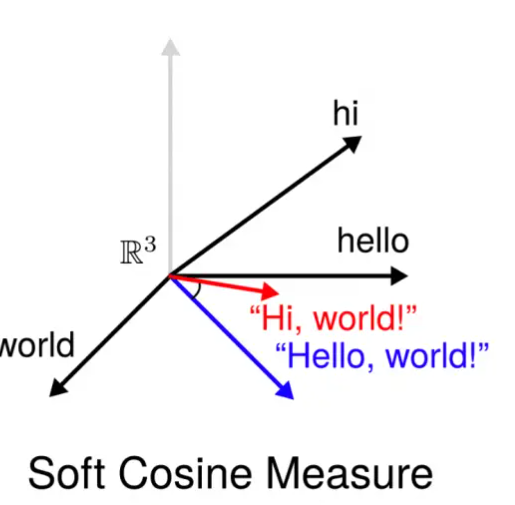

In [80]:
token1 = nlp('hi world')
token1

hi world

In [79]:
token2 = nlp('hello world')
token2

hello world

In [81]:
print(f'Similarity between words "{token1}" and "{token2}" = {100*token2.similarity(token1)} %')

Similarity between words "hi world" and "hello world" = 78.44660035133562 %


In [82]:
print(f'Similarity between words "{token1[0]}" and "{token1[1]}" = {100*token1[0].similarity(token1[1])} %')

Similarity between words "hi" and "world" = 26.470011472702026 %


### Let's compare longer texts now (our licenses)

One common use case for natural language work is to compare texts. For example, with those open source licenses we can download their text, parse, then compare [similarity](https://spacy.io/api/doc#similarity) metrics among them:

In [48]:
pairs = [
    ["mit", "asl"],
    ["asl", "bsd"],
    ["bsd", "mit"]
]

for a, b in pairs:
    print(a, b, lic[a].similarity(lic[b]))

mit asl 0.8862448744868231
asl bsd 0.8782760959660898
bsd mit 0.9709998634392837


That is interesting, since the [BSD](https://opensource.org/licenses/BSD-3-Clause) and [MIT](https://opensource.org/licenses/MIT) licenses appear to be the most similar documents.
In fact they are closely related.

Admittedly, there was some extra text included in each document due to the OSI disclaimer in the footer – but this provides a reasonable approximation for comparing the licenses.

More examples:
https://spacy.io/usage/linguistic-features#vectors-similarity
https://www.machinelearningplus.com/nlp/cosine-similarity/